<a href="https://colab.research.google.com/github/koushikchimakurthi/cats_dogs_classification/blob/master/CatsvsDogsUsingTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from shutil import copyfile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-09-11 05:22:34--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.248.137, 2600:1409:3000:4ab::e59, 2600:1409:3000:48e::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.248.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   124MB/s    in 6.5s    

2020-09-11 05:22:41 (121 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
import zipfile
local_zip = '/tmp/cats-and-dogs.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
  zip_ref.extractall('/tmp')

In [4]:
import os
try:
  os.mkdir('/tmp/cats-and-dogs')
  os.mkdir('/tmp/cats-and-dogs/training')
  os.mkdir('/tmp/cats-and-dogs/testing')
  os.mkdir('/tmp/cats-and-dogs/training/cats')
  os.mkdir('/tmp/cats-and-dogs/training/dogs')
  os.mkdir('/tmp/cats-and-dogs/testing/cats')
  os.mkdir('/tmp/cats-and-dogs/testing/dogs')
except OSError:
  pass

In [5]:
def split_data(Source, Training, Testing, Split_size):
  files=[]
  for filename in os.listdir(Source):
    file = Source + filename
    if os.path.getsize(file)>0:
      files.append(filename)
    else:
      print("{} is of zero length, so ignoring..".format(filename))

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = Source + filename
    destination = Training + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = Source + filename
    destination = Testing + filename
    copyfile(this_file, destination)


cats_source_dir = '/tmp/PetImages/Cat/'
cats_training_dir = '/tmp/cats-and-dogs/training/cats/'
cats_testing_dir = '/tmp/cats-and-dogs/testing/cats/'
dogs_source_dir = '/tmp/PetImages/Dog/'
dogs_training_dir = '/tmp/cats-and-dogs/training/dogs/'
dogs_testing_dir = '/tmp/cats-and-dogs/testing/dogs/'

split_size= 0.9
split_data(cats_source_dir, cats_training_dir, cats_testing_dir, split_size)
split_data(dogs_source_dir, dogs_training_dir, dogs_testing_dir, split_size)

666.jpg is of zero length, so ignoring..
11702.jpg is of zero length, so ignoring..


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-11 05:23:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  78.0MB/s    in 1.1s    

2020-09-11 05:23:11 (78.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                weights = None,
                                include_top = False)

In [9]:
pre_trained_model.load_weights(local_weights_file)

In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer_output_shape = last_layer.output_shape
print("Last layer output shape : {}".format(last_layer_output_shape))
last_layer_output = last_layer.output

Last layer output shape : (None, 7, 7, 768)


In [13]:
model = keras.layers.Flatten()(last_layer_output)
model = keras.layers.Dense(1024, activation='relu')(model)
model = keras.layers.Dense(1, activation='sigmoid')(model)

model = Model(pre_trained_model.input, model)

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
training_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 40,
                                      width_shift_range = 0.2,
                                      height_shift_range = 0.2,
                                      shear_range = 0.2,
                                      fill_mode = 'nearest',
                                      horizontal_flip = True)
train_generator = training_datagen.flow_from_directory('/tmp/cats-and-dogs/training',
                                                       target_size = (150,150),
                                                       batch_size = 64,
                                                       class_mode = 'binary')

testing_datagen = ImageDataGenerator(rescale = 1/255)
validation_generator = testing_datagen.flow_from_directory('/tmp/cats-and-dogs/testing',
                                                           target_size = (150,150),
                                                           batch_size = 32,
                                                           class_mode = 'binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [18]:
class my_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if logs.get('accuracy')>0.95:
      print('\nAccuracy reached 95%, stopping training..')
      self.model.stop_training = True

In [19]:
history = model.fit_generator(generator=train_generator,
                              epochs = 20,
                              callbacks = [my_callback()],
                              validation_data = validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
184/352 [==============>...............] - ETA: 1:16 - loss: 0.2603 - accuracy: 0.8988

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 173s 491ms/step - loss: 0.2099 - accuracy: 0.9163 - val_loss: 0.1800 - val_accuracy: 0.9380
Epoch 2/20
352/352 [==============================] - 176s 500ms/step - loss: 0.1450 - accuracy: 0.9415 - val_loss: 0.1204 - val_accuracy: 0.9596
Epoch 3/20
352/352 [==============================] - 179s 510ms/step - loss: 0.1368 - accuracy: 0.9472 - val_loss: 0.1009 - val_accuracy: 0.9656
Epoch 4/20
352/352 [==============================] - 180s 510ms/step - loss: 0.1321 - accuracy: 0.9496 - val_loss: 0.0960 - val_accuracy: 0.9672
Epoch 5/20
352/352 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9526
Accuracy reached 95%, stopping training..
352/352 [==============================] - 180s 512ms/step - loss: 0.1277 - accuracy: 0.9526 - val_loss: 0.0883 - val_accuracy: 0.9724


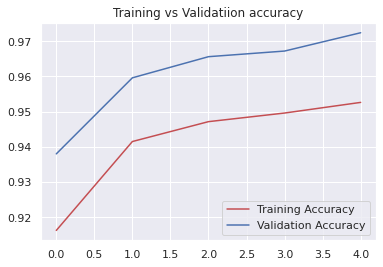

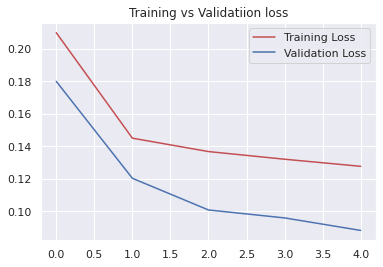

In [23]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label = 'Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training vs Validatiion accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training vs Validatiion loss')
plt.legend()
plt.show()